# Univariate LSTM - Single asset (in-sample) prediction
## 1. Import Libraries

In [23]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data
import math
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#LSTM RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

#Check for stationarity
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-darkgrid')
%matplotlib inline


Some helpful resources

(Multi stock prediction w single nn)[https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn]
(LSTM math)[https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235]

Root of mean squared error (helper fn)

In [4]:
def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [44]:
#Import single asset: GLD

def GetData(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'.csv', usecols=['Date','Adj Close'], parse_dates=True, index_col='Date' ).astype('float32').dropna()

def GetVol(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'.csv', usecols=['Date','Volume'], parse_dates=True, index_col='Date' ).astype('float32').dropna()

Text(0.5, 0, 'Time')

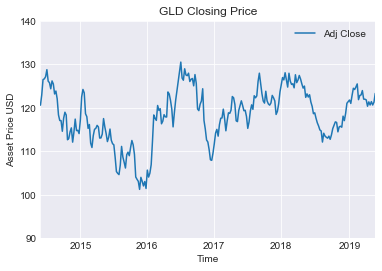

In [11]:
data_GLD = GetData('GLD')
data_GLD.plot()
plt.title('GLD Closing Price')
plt.ylabel('Asset Price USD')
plt.ylim(90,140)
plt.xlabel('Time')

### Univariate LSTM - Single Asset

In [13]:
#train-test split
split_date = '2018-01-01'

train = data_GLD[data_GLD.index<split_date]
test = data_GLD[data_GLD.index>=split_date]

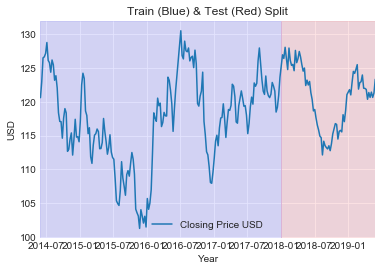

      Training set consists of 72.0% of data


In [21]:
plt.plot(data_GLD)
plt.axvspan(data_GLD.index[0], split_date, color='blue', alpha=0.1)
plt.axvspan(split_date, data_GLD.index[-1], color='red', alpha=0.1)
plt.xlim(data_GLD.index[0],data_GLD.index[-1])
plt.title('Train (Blue) & Test (Red) Split')
plt.legend(['Closing Price USD'])
plt.xlabel('Year')
plt.ylabel('USD')

plt.show()
print('      Training set consists of {}% of data'.format(round(train.shape[0]/data_GLD.shape[0],2)*100))


Use MinMaxScaler() to scale NN values to between 0,1. Then, reshape to ensure shape match.
* Q is the week-ahead for prediction

In [24]:
mm = MinMaxScaler()

train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

test = np.reshape(test.values, (len(test),1))
test = mm.transform(test)

Q = 1
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

X_test = test[0:len(test)-Q]
y_test = test[Q:len(test)]

X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

* defines early stopping patience and lstm node count
* use MSE instead of MAE due to potentially small spread in errors

In [33]:
patience = 15
lstm_nodes = 32

In [34]:
Univar_LSTM = 'reset'
# designing NN
Univar_LSTM = Sequential()
Univar_LSTM.add(LSTM(lstm_nodes, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
Univar_LSTM.add(Dense(1))
Univar_LSTM.compile(optimizer='adam', loss='mse')
# fit NN
history_univar = Univar_LSTM.fit(X_train, y_train, batch_size=1, epochs=100, 
                           validation_data=(X_test, y_test), callbacks = [EarlyStopping(monitor='value_loss', patience=patience)],
                          verbose=-1)

Train on 186 samples, validate on 73 samples
Epoch 1/100


//anaconda3/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `value_loss` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

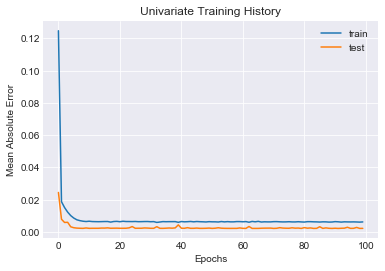

In [35]:
# plot history
plt.plot(history_univar.history['loss'], label='train')
plt.plot(history_univar.history['val_loss'], label='test')
plt.title('Univariate Training History')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [36]:
#finding predictions for testing data
predicted_univar = Univar_LSTM.predict(X_test)
predicted_univar = mm.inverse_transform(predicted_univar)[:,0]

y_true = mm.inverse_transform(y_test)

In [39]:
#building dataframe of predictions values
pred = pd.DataFrame({'True':y_true.flatten(),'Pred_Univar':predicted_univar.flatten()})
pred.index = data_GLD[data_GLD.index>=split_date][:-1].index

In [40]:
#percent change per day, difference between
change_pct = pred.pct_change()[1:]
change_pct = change_pct[1:]
change_pct['Univar'] = change_pct['True'] - change_pct['Pred_Univar']
change_pct['Tru'] = 0
change_pct.index = data_GLD[data_GLD.index>=split_date][1:-2].index

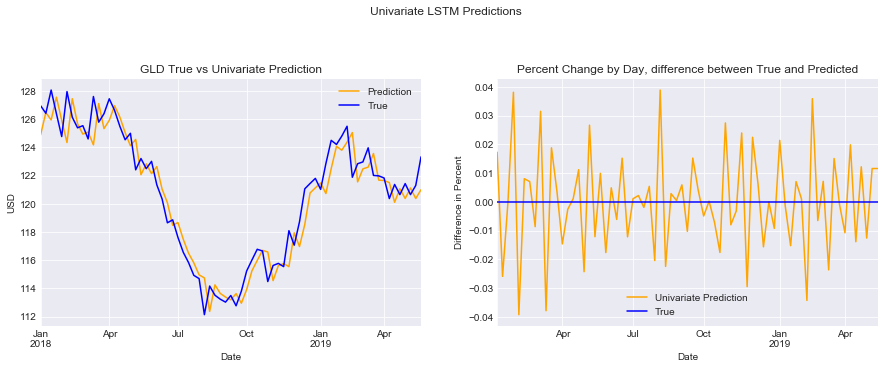

In [43]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('Univariate LSTM Predictions')

plt.subplot(221)
pred.Pred_Univar.plot(c='orange')
pred['True'].plot(c='blue')
plt.legend(['Prediction','True'])
plt.title('GLD True vs Univariate Prediction')
plt.ylabel('USD')
plt.xlabel('Date')

plt.subplot(222)
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
change_pct.Univar.plot(c='orange')
change_pct.Tru.plot(c= 'blue')
plt.legend(['Univariate Prediction','True']);
*plt.show()

Observations:
* Univariate LSTM tends to under-estimate GLD values
* To rectify:
    * Increase the number of features
    * Increase the training to overcome over- or under-fitting

# MULTIVARIATE LSTM - Single asset (in-sample) prediction

In [51]:
#import market and econ data
%store -r data_gdp
%store -r data_savings
%store -r data_vix

In [52]:
GLD_vol = GetVol('GLD')

In [53]:
#market and econ data
data_m = pd.concat([data_savings,data_vix],axis=1)
data_m = data_m.fillna(method='ffill')

In [56]:
data_all = pd.concat([data_GLD,GLD_vol,data_m],axis=1).dropna()
data_all.columns = ['Adj_Close','Volume','Savings','VIX']
data_all

,Adj_Close,Volume,Savings,VIX
Date,,,,
2014-06-02,120.610001,23772000.0,7.5,11.580000
2014-06-09,122.959999,21332000.0,7.5,11.150000
2014-06-16,126.500000,48796800.0,7.5,12.650000
2014-06-23,126.660004,27915400.0,7.5,10.980000
2014-06-30,127.160004,36930700.0,7.5,11.570000
2014-07-07,128.779999,29844900.0,7.5,11.330000
2014-07-14,126.129997,43991800.0,7.5,11.820000
2014-07-21,125.790001,23970100.0,7.5,12.810000
2014-07-28,124.379997,31388900.0,7.5,12.560000


In [57]:
# convert time series to supervised learning
# Using one lag observation as input (x)
# Using one observation as output (y)
def convert_ts_to_supervised(data_in):
    n_vars = 1 if type(data_in) is list else data_all.shape[1]
    df = pd.DataFrame(data_in)
    y = list()
    names = list()
    # Build input sequence
    y.append(df.shift(1))
    names += [('var%d(t-%d)' % (j+1, 1)) for j in range(n_vars)]
    
    # Build forecast sequence 
    y.append(df.shift(-1))
    names += [('var%d(t+%d)' % (j+1, 1)) for j in range(n_vars)]
    
    # Combine input and forecast sequence
    combined_data = pd.concat(y, axis=1)
    combined_data.columns = names

    # Remove missing values
    combined_data.dropna(inplace=True)
    return combined_data


In [58]:
def plot_features(data):
    # Plot only the features:
    # GLD_close price, Savings, VIX_close price
    num_features = [0, 1, 2]
    i = 1
    pyplot.figure(figsize=(10,8))
    for n in num_features:
        pyplot.subplot(len(num_features), 1, i)
        pyplot.plot(values[:, n])
        pyplot.title(data.columns[n], y=0.6, loc='left')
        i += 1
    pyplot.show()


In [59]:
#Engineer the features: normalization and transformation
scaler = MinMaxScaler(feature_range=(0,1))
scaled_in = scaler.fit_transform(data_all)
print(scaled_in)

[[0.69816097 0.08928237 0.48       0.07133758]
 [0.78290669 0.0675301  0.48       0.05764331]
 [0.91056631 0.31237508 0.48       0.10541401]
 [0.91633637 0.12622022 0.48       0.0522293 ]
 [0.93436739 0.2065904  0.48       0.0710191 ]
 [0.9927877  0.14342145 0.48       0.06337579]
 [0.89722326 0.26953915 0.48       0.07898089]
 [0.8849623  0.09104841 0.48       0.11050955]
 [0.83411471 0.15718601 0.48       0.10254776]
 [0.89938717 0.20896265 0.4        0.18407642]
 [0.87378316 0.12839812 0.4        0.15573247]
 [0.79120108 0.11783223 0.4        0.09490445]
 [0.81536257 0.04185262 0.4        0.07515923]
 [0.7504508  0.09438078 0.48       0.08757961]
 [0.61774251 0.20207146 0.48       0.10573248]
 [0.57122246 0.19782531 0.48       0.15222929]
 [0.57014064 0.14122305 0.48       0.13853502]
 [0.48178877 0.22405373 0.48       0.21146495]
 [0.58925347 0.18805551 0.4        0.19490445]
 [0.63974037 0.18607373 0.4        0.48726108]
 [0.6166607  0.06785193 0.4        0.29394903]
 [0.41146792 

In [60]:
#Convert TS to supervised learning model
reframed = convert_ts_to_supervised(scaled_in)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t+1)  var2(t+1)  \
1   0.698161   0.089282       0.48   0.071338   0.910566   0.312375   
2   0.782907   0.067530       0.48   0.057643   0.916336   0.126220   
3   0.910566   0.312375       0.48   0.105414   0.934367   0.206590   
4   0.916336   0.126220       0.48   0.052229   0.992788   0.143421   
5   0.934367   0.206590       0.48   0.071019   0.897223   0.269539   

   var3(t+1)  var4(t+1)  
1       0.48   0.105414  
2       0.48   0.052229  
3       0.48   0.071019  
4       0.48   0.063376  
5       0.48   0.078981  


In [63]:
# Predict only y=GLD_Close(t+1)
# Drop columns Savings(t+1) and VIX_Close(t+1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)
1   0.698161   0.089282       0.48   0.071338
2   0.782907   0.067530       0.48   0.057643
3   0.910566   0.312375       0.48   0.105414
4   0.916336   0.126220       0.48   0.052229
5   0.934367   0.206590       0.48   0.071019


In [64]:
# Split into 80% train and 20% test data
values = reframed.values
train_80pct = int(len(values)* 0.8)


In [65]:
train = values[:train_80pct, :]
test = values[train_80pct:, :]

In [66]:
# Split training and test data into input(x) and output(y)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [67]:
# Reshape for LSTM network: [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [69]:
# Design network and fit the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
fitted = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 188 samples, validate on 48 samples
Epoch 1/200
 - 3s - loss: 0.0774 - val_loss: 0.0984
Epoch 2/200
 - 0s - loss: 0.0709 - val_loss: 0.0901
Epoch 3/200
 - 0s - loss: 0.0649 - val_loss: 0.0824
Epoch 4/200
 - 0s - loss: 0.0593 - val_loss: 0.0752
Epoch 5/200
 - 0s - loss: 0.0542 - val_loss: 0.0685
Epoch 6/200
 - 0s - loss: 0.0496 - val_loss: 0.0624
Epoch 7/200
 - 0s - loss: 0.0454 - val_loss: 0.0569
Epoch 8/200
 - 0s - loss: 0.0416 - val_loss: 0.0518
Epoch 9/200
 - 0s - loss: 0.0382 - val_loss: 0.0473
Epoch 10/200
 - 0s - loss: 0.0352 - val_loss: 0.0432
Epoch 11/200
 - 0s - loss: 0.0325 - val_loss: 0.0395
Epoch 12/200
 - 0s - loss: 0.0303 - val_loss: 0.0363
Epoch 13/200
 - 0s - loss: 0.0283 - val_loss: 0.0336
Epoch 14/200
 - 0s - loss: 0.0267 - val_loss: 0.0312
Epoch 15/200
 - 0s - loss: 0.0253 - val_loss: 0.0292
Epoch 16/200
 - 0s - loss: 0.0242 - val_loss: 0.0275
Epoch 17/200
 - 0s - loss: 0.0233 - val_loss: 0.0261
Epoch 18/200
 - 0s - loss: 0.0227 - val_loss: 0.0250
Epoch 19/2

Epoch 154/200
 - 0s - loss: 0.0153 - val_loss: 0.0169
Epoch 155/200
 - 0s - loss: 0.0153 - val_loss: 0.0169
Epoch 156/200
 - 0s - loss: 0.0153 - val_loss: 0.0169
Epoch 157/200
 - 0s - loss: 0.0152 - val_loss: 0.0169
Epoch 158/200
 - 0s - loss: 0.0152 - val_loss: 0.0169
Epoch 159/200
 - 0s - loss: 0.0152 - val_loss: 0.0169
Epoch 160/200
 - 0s - loss: 0.0152 - val_loss: 0.0169
Epoch 161/200
 - 0s - loss: 0.0151 - val_loss: 0.0168
Epoch 162/200
 - 0s - loss: 0.0151 - val_loss: 0.0168
Epoch 163/200
 - 0s - loss: 0.0151 - val_loss: 0.0168
Epoch 164/200
 - 0s - loss: 0.0151 - val_loss: 0.0168
Epoch 165/200
 - 0s - loss: 0.0151 - val_loss: 0.0168
Epoch 166/200
 - 0s - loss: 0.0150 - val_loss: 0.0168
Epoch 167/200
 - 0s - loss: 0.0150 - val_loss: 0.0168
Epoch 168/200
 - 0s - loss: 0.0150 - val_loss: 0.0167
Epoch 169/200
 - 0s - loss: 0.0150 - val_loss: 0.0167
Epoch 170/200
 - 0s - loss: 0.0150 - val_loss: 0.0167
Epoch 171/200
 - 0s - loss: 0.0149 - val_loss: 0.0167
Epoch 172/200
 - 0s - loss: 

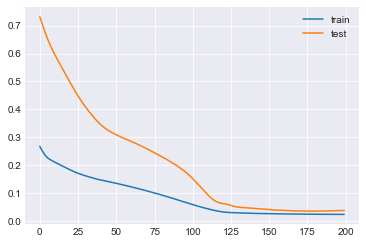

In [45]:
# Plot istory
plt.plot(fitted.history['loss'], label='train')
plt.plot(fitted.history['val_loss'], label='test')
plt.legend()
plt.show()

In [48]:
# Predict SP500 Close Price
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [61]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [63]:
# Reverse scaling to get actual value
test_y = test_y.reshape((len(test_y), 1))
rev_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
rev_y = scaler.inverse_transform(rev_y)
rev_y = rev_y[:,0]
print (rev_y)

[164.812607 162.422043 160.55838  152.889053 155.552811 154.664886
 154.138    153.659866 152.4207   154.83075  157.240845 155.513794
 158.294647 157.918076 162.297058 164.2509   163.543991 160.843964
 164.447281 170.19101  173.539063 182.562119 184.182129 178.624954
 185.085403 180.744049 181.070038 172.040756 173.433685 176.120728
 180.161194 180.35878  174.579636 172.633499 177.790268 182.808746
 178.454926 184.250992 185.722366 188.794373 189.59967  190.484482
 193.775208 196.270599 196.370026 198.825638 198.06012  196.618561]


In [68]:
# Calculate and print RMSE
rmse = math.sqrt(mean_squared_error(rev_y, inv_yhat))
print('RMSE Result: %.5f' % rmse)

RMSE Result: 5.81737
